In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install torchview
!pip install torchviz

In [2]:
import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
libc = ctypes.CDLL("libc.so.6")

In [3]:
X_train = np.load('/DATA/Shashank/X_pretrain.npy')

In [4]:
X_train.shape

(40000, 125, 125, 8)

In [5]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


In [6]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
        imgs = self.patchify(x)
        
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        
        
        return x, mask, ids_restore, imgs
    
class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def forward(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio
        
    def forward(self, x):
        x, mask, ids_restore, imgs = self.encoder(x)
        pred = self.decoder(x, ids_restore)
        
        return imgs, pred, mask
    
def mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=8, num_heads=12,
        decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=8, num_heads=12,
        decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model

# Instantiate the model
model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75)

In [7]:
model = torch.load('/DATA/Shashank/model.pth')

In [ ]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

# encoder = Encoder(
#         img_size=125, patch_size=5, embed_dim=768, depth=8, num_heads=12,
#         decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
#         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6)
# encoder = model.encoder

model_graph = draw_graph(model, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [ ]:
# import torchvision
# from torchview import draw_graph
# from torchviz import make_dot

# # encoder = Encoder(
# #         img_size=125, patch_size=5, embed_dim=768, depth=8, num_heads=12,
# #         decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
# #         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6)
# encoder = model.encoder

# model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
# model_graph.visual_graph

In [ ]:
x = torch.rand((1,8,125,125)).to('cuda')
x, mask, imhgs = model(x)
mask

In [ ]:
# class MaskedAutoencoderViT(nn.Module):
#     """ Masked Autoencoder with VisionTransformer backbone
#     """
#     def __init__(self, img_size=224, patch_size=16, in_chans=8,
#                  embed_dim=1024, depth=24, num_heads=16,
#                  decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
#                  mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
#         super().__init__()

#         # --------------------------------------------------------------------------
#         # MAE encoder specifics
#         self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
#         num_patches = self.patch_embed.num_patches

#         self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
#         self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

#         self.blocks = nn.ModuleList([
#             Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
#             for i in range(depth)])
#         self.norm = norm_layer(embed_dim)
#         # --------------------------------------------------------------------------

#         # --------------------------------------------------------------------------
#         # MAE decoder specifics
#         self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

#         self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

#         self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

#         self.decoder_blocks = nn.ModuleList([
#             Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
#             for i in range(decoder_depth)])

#         self.decoder_norm = norm_layer(decoder_embed_dim)
#         self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
#         # --------------------------------------------------------------------------

#         self.norm_pix_loss = norm_pix_loss

#         self.initialize_weights()

#     def initialize_weights(self):
#         # initialization
#         # initialize (and freeze) pos_embed by sin-cos embedding
#         pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
#         self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

#         decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
#         self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

#         # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
#         w = self.patch_embed.proj.weight.data
#         torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

#         # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
#         torch.nn.init.normal_(self.cls_token, std=.02)
#         torch.nn.init.normal_(self.mask_token, std=.02)

#         # initialize nn.Linear and nn.LayerNorm
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             # we use xavier_uniform following official JAX ViT:
#             torch.nn.init.xavier_uniform_(m.weight)
#             if isinstance(m, nn.Linear) and m.bias is not None:
#                 nn.init.constant_(m.bias, 0)
#         elif isinstance(m, nn.LayerNorm):
#             nn.init.constant_(m.bias, 0)
#             nn.init.constant_(m.weight, 1.0)

#     def patchify(self, imgs):
#         """
#         imgs: (N, 8, H, W)
#         x: (N, L, patch_size**2 *3)
#         """
#         p = self.patch_embed.patch_size[0]
#         assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

#         h = w = imgs.shape[2] // p
#         x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
#         x = torch.einsum('nchpwq->nhwpqc', x)
#         x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
#         return x

#     def unpatchify(self, x):
#         """
#         x: (N, L, patch_size**2 *3)
#         imgs: (N, 8, H, W)
#         """
#         p = self.patch_embed.patch_size[0]
#         h = w = int(x.shape[1]**.5)
#         assert h * w == x.shape[1]
        
#         x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
#         x = torch.einsum('nhwpqc->nchpwq', x)
#         imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
#         return imgs

#     def random_masking(self, x, mask_ratio):
#         """
#         Perform per-sample random masking by per-sample shuffling.
#         Per-sample shuffling is done by argsort random noise.
#         x: [N, L, D], sequence
#         """
#         N, L, D = x.shape  # batch, length, dim
#         len_keep = int(L * (1 - mask_ratio))
        
#         noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
#         # sort noise for each sample
#         ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
#         ids_restore = torch.argsort(ids_shuffle, dim=1)

#         # keep the first subset
#         ids_keep = ids_shuffle[:, :len_keep]
#         x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

#         # generate the binary mask: 0 is keep, 1 is remove
#         mask = torch.ones([N, L], device=x.device)
#         mask[:, :len_keep] = 0
#         # unshuffle to get the binary mask
#         mask = torch.gather(mask, dim=1, index=ids_restore)

#         return x_masked, mask, ids_restore

#     def forward_encoder(self, x, mask_ratio):
#         # embed patches
#         x = self.patch_embed(x)

#         # add pos embed w/o cls token
#         x = x + self.pos_embed[:, 1:, :]

#         # masking: length -> length * mask_ratio
#         x, mask, ids_restore = self.random_masking(x, mask_ratio)

#         # append cls token
#         cls_token = self.cls_token + self.pos_embed[:, :1, :]
#         cls_tokens = cls_token.expand(x.shape[0], -1, -1)
#         x = torch.cat((cls_tokens, x), dim=1)

#         # apply Transformer blocks
#         for blk in self.blocks:
#             x = blk(x)
#         x = self.norm(x)

#         return x, mask, ids_restore

#     def forward_decoder(self, x, ids_restore):
#         # embed tokens
#         x = self.decoder_embed(x)

#         # append mask tokens to sequence
#         mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
#         x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
#         x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

#         # add pos embed
#         x = x + self.decoder_pos_embed

#         # apply Transformer blocks
#         for blk in self.decoder_blocks:
#             x = blk(x)
#         x = self.decoder_norm(x)

#         # predictor projection
#         x = self.decoder_pred(x)

#         # remove cls token
#         x = x[:, 1:, :]

#         return x

#     def forward(self, imgs, mask_ratio=0.75):
#         latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
#         pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
# #         loss = self.forward_loss(imgs, pred, mask)
#         imgs = self.patchify(imgs)
#         return imgs, pred, mask


# # def mae_vit_base_patch16_dec512d8b(**kwargs):
# #     model = MaskedAutoencoderViT(
# #         img_size=125,patch_size=5, embed_dim=768, depth=12, num_heads=12,
# #         decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
# #         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
# #     return model


# # # set recommended archs
# # model = mae_vit_base_patch16_dec512d8b (img_size = 125) # decoder: 512 dim, 8 blocks
# def mae_vit_base_patch16_dec512d8b(img_size=125, **kwargs):
#     model = MaskedAutoencoderViT(
#         img_size=img_size, patch_size=5, embed_dim=768, depth=8, num_heads=12,
#         decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
#         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

# # Instantiate the model
# model = mae_vit_base_patch16_dec512d8b(img_size=125)


In [ ]:
# x = torch.rand((1,8,125,125))
# op = model.forward_encoder(x, 0.75)

In [9]:
import torchvision
# from torchview import draw_graph
# model_graph = draw_graph(model, input_size=(16,8,125,125), expand_nested=True)
# model_graph.visual_graph      

In [10]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, transform):
        self.x = x
#         self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = (self.x[idx])
#         img_2 = (self.y[idx])
        
#         img_1 = torch.tensor(self.Patchify(img_1.detach().numpy()))
#         img_2 = torch.tensor(self.Patchify(img_2.detach().numpy()))
        
        
        if self.transform:
            img_1 = self.transform(img_1)
#             img_2 = self.transform(img_2)
            
        sample = {'img' : img_1}
        
        return sample
    
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = Custom_Dataset(X_train, transform = transform)
sample = dataset.__getitem__(0)
print((sample['img']).shape)
# print(sample['label'].shape)

torch.Size([8, 125, 125])


torch.Size([8, 125, 125])


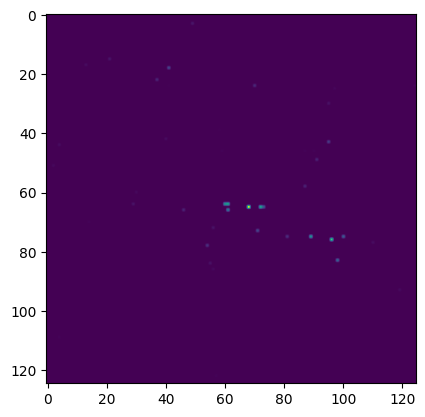

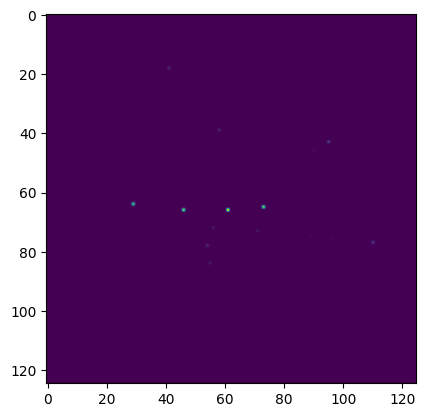

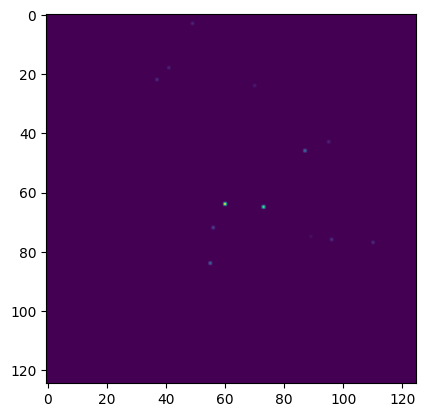

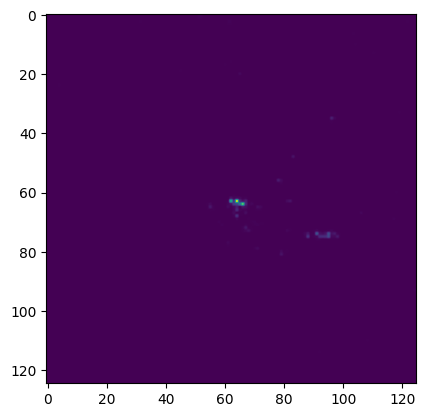

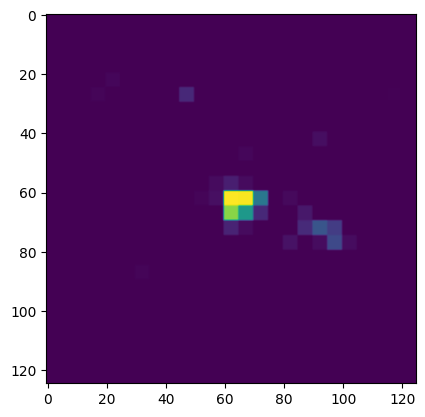

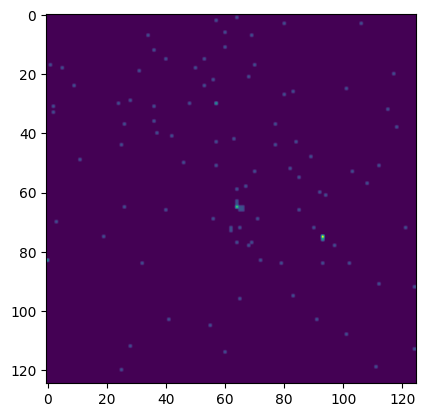

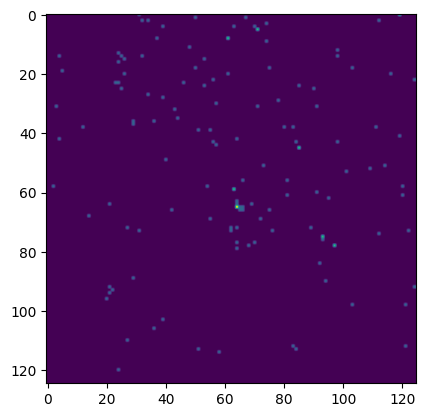

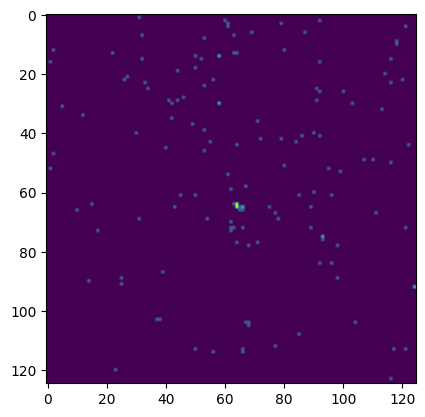

In [11]:
# !pip install torchviz
sample = dataset.__getitem__(0)
print((sample['img']).shape)

img = sample['img'].permute(1,2,0)
img = img.cpu().detach().numpy()

import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

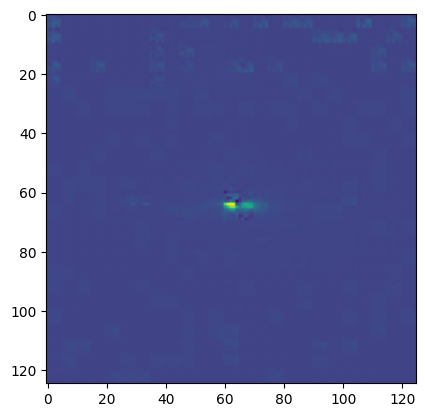

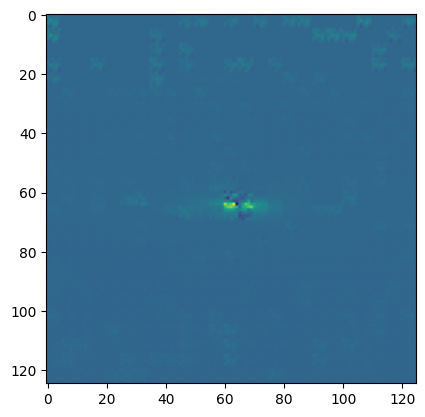

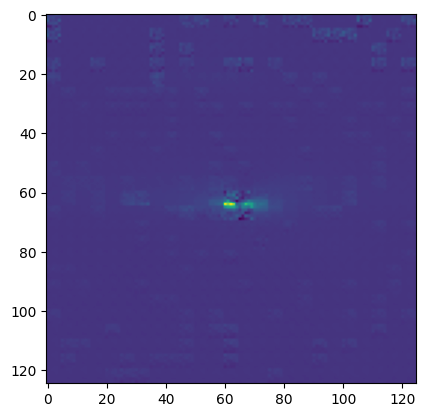

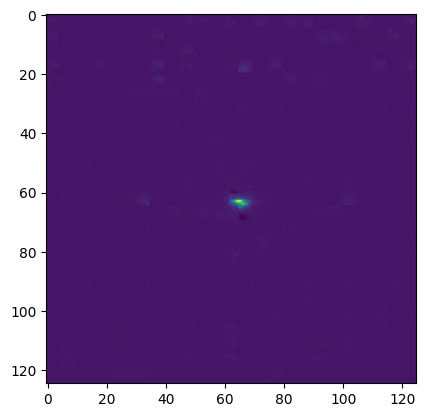

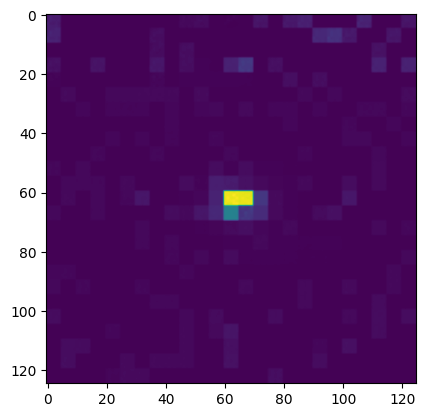

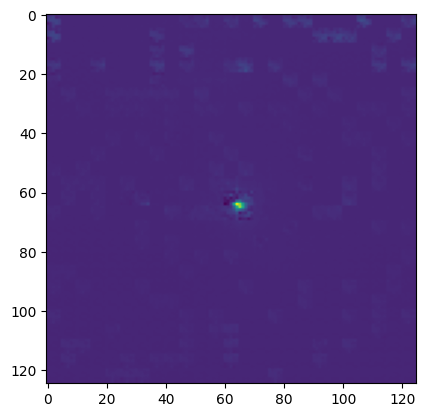

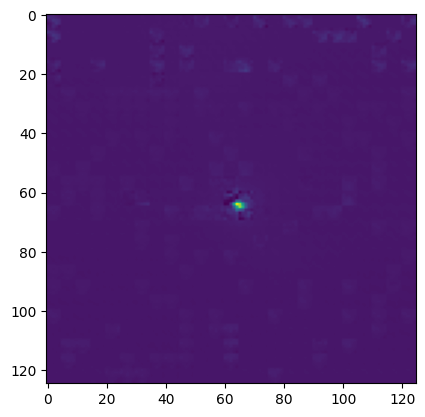

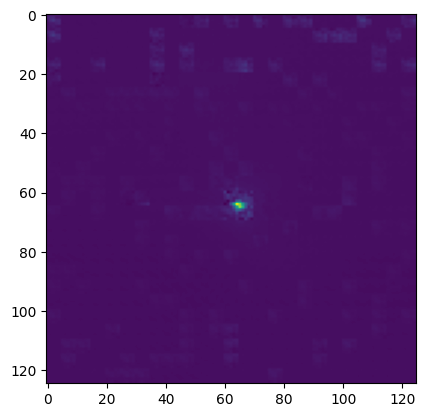

In [14]:
imgs, pred, ind = model(sample['img'].unsqueeze(0).to('cuda'))

pred.shape

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 8, H, W)
    """
    p = 5
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
    return imgs

# pred = pred.reshape((125,125,8))
pred = unpatchify(pred)
pred.shape
pred = pred.reshape((8, 125, 125))
pred.shape

img = pred.permute(1,2,0)
img = img.cpu().detach().numpy()

import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

In [ ]:
# sample['img'].max()

In [ ]:
def custom_loss(imgs, pred, mask):
    """
    imgs: [N, 3, H, W]
    pred: [N, L, p*p*3]
    mask: [N, L], 0 is keep, 1 is remove, 
    """
    target = imgs
#     if self.norm_pix_loss:
#         mean = target.mean(dim=-1, keepdim=True)
#         var = target.var(dim=-1, keepdim=True)
#         target = (target - mean) / (var + 1.e-6)**.5

    loss = (pred - target) ** 2
    loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

    loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
    return loss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def channel_wise_visualization(original_image, reconstructed_image):
    """
    Visualize each channel of the original and reconstructed images separately.
    
    Args:
        original_image (numpy.ndarray): Original image with shape (height, width, channels).
        reconstructed_image (numpy.ndarray): Reconstructed image with shape (height, width, channels).
    """
    original_image = original_image  # Rescale back to original range
    reconstructed_image = reconstructed_image  # Rescale back to original range
    
    num_channels = 8
    
    fig, axs = plt.subplots(2, num_channels, figsize=(15, 5))
    
    for i in range(num_channels):
        axs[0, i].imshow(original_image[:, :, i])
        axs[0, i].set_title(f'Original Channel {i+1}')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(reconstructed_image[:, :, i])
        axs[1, i].set_title(f'Reconstructed  {i+1}')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
original_image = np.random.rand(128, 128, 8)  # Example original image with 8 channels
reconstructed_image = np.random.rand(128, 128, 8)  # Example reconstructed image with 8 channels

channel_wise_visualization(original_image, reconstructed_image)
# error_map(original_image, reconstructed_image)


In [ ]:
# from torchmetrics import Accuracy
# import copy
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim 
# import tqdm
# from tqdm import tqdm
# from torchmetrics import Accuracy


# def model_train(model, epochs, train_dataloader, test_dataloader):
#     # Loss function and optimizer
    
# #     criterion = nn.MSELoss()  # Mean Squared Error Loss
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
# #     accuracy = Accuracy(task = 'binary').to(DEVICE)
 
#     # Hold the best model
# #     best_acc = -np.inf  # Init to negative infinity
# #     best_weights = None

#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []

#     for epoch in tqdm(range(epochs), desc='Epochs', unit='epoch'):
#         train_pred = []
#         val_pred = []

#         model.train()
#         for batch in train_dataloader:
#             images, labels = batch['img'], batch['label']
#             images = images.to(DEVICE).float()
#             labels = labels.to(DEVICE).float()

#             optimizer.zero_grad()
        
#             imgs, outputs, ind = model(images)
            
#             ind = torch.tensor(ind)
#             ind = ind.to(DEVICE)
#             loss = custom_loss(imgs, outputs, ind)
            
#             loss.backward()
#             optimizer.step()

#             train_pred.append(loss.item())

#         train_loss = np.mean(train_pred)

#         model.eval()
#         with torch.no_grad():
#             for val_batch in test_dataloader:
#                 val_images, val_labels = val_batch['img'], val_batch['label']
#                 val_images = val_images.to(DEVICE).float()
#                 val_labels = val_labels.to(DEVICE).float()

#                 imgs, val_outputs, ind = model(val_images)
#                 ind = torch.tensor(ind)
#                 ind = ind.to(DEVICE)
                
#                 val_loss = custom_loss(imgs, val_outputs, ind)
#                 val_pred.append(val_loss.item())
                
#             for val_batch in test_dataloader:
#                 val_images, val_labels = val_batch['img'], val_batch['label']
#                 val_images = val_images.to(DEVICE).float()
#                 val_labels = val_labels.to(DEVICE).float()

#                 preds, val_outputs, ind = model(val_images)
#                 val_images = val_images.reshape((val_images.shape[0], 125,125,8)).cpu().detach().numpy()
#                 val_outputs = val_outputs.reshape((val_images.shape[0], 125,125,8)).cpu().detach().numpy()
#                 channel_wise_visualization(val_outputs[0,:,:,:], val_images[0,:,:,:])
                
#                 error_map(val_outputs[0,:,:,:], val_images[0,:,:,:])
                
#                 break
#                 # Calculate validation accuracy
# #                 val_acc = accuracy(val_outputs, val_labels)
# #                 val_accuracies.append(val_acc.item())

#         val_loss = np.mean(val_pred)

#         # Print and store losses and accuracies
#         print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

# #         # Save best model
# #         if max(train_accuracies) > best_acc:
# #             best_acc = max(train_accuracies)
# #             best_weights = copy.deepcopy(model.state_dict())
            
# #         model.load_state_dict(best_weights)
    
#     # Save the best model
#     torch.save(model, './best_model_.pth')

#     # Plot training and validation losses
#     return train_losses, val_losses
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn as nn
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy

# Define your Custom_Dataset class here (assuming it's defined earlier)

# Define your MaskedAutoencoderViT class here (assuming it's defined earlier)

def model_train(model, epochs, train_dataloader, val_dataloader, device):
#     criterion = custom_loss()
    optimizer = AdamW(model.parameters(), lr=1.5e-4, weight_decay=0.05)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=40, T_mult=2)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        model.train()
        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            images = batch['img'].to(device).float()

            optimizer.zero_grad()
            imgs, outputs, ind = model(images)
            loss = custom_loss(imgs, outputs, ind)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{epochs} (Val)', unit='batch'):
                images = batch['img'].to(device).float()

                imgs, val_outputs, ind = model(images)
                loss = custom_loss(imgs, val_outputs, ind)

                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        with open('losses.txt', 'a') as f:  # Open file in append mode
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')
    
        torch.save(model, f'./best_model.pth')
    
    return train_losses, val_losses

# Assuming dataset, train_dataloader, and val_dataloader are defined earlier

# Define your model
# del model
gc.collect()
torch.cuda.empty_cache()



In [ ]:
del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = mae_vit_base_patch16_dec512d8b(img_size=125)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
training_loss = []
validation_loss = []
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

DEVICE = torch.torch.device("cuda")
NUM_GPU = torch.cuda.device_count()
if NUM_GPU > 1:
    model = nn.DataParallel(model)
model = model.to(DEVICE)

train_losses, val_losses = model_train(model, 500, train_dataloader, val_dataloader, DEVICE)


In [ ]:
# torch.save(model, f'./best_model.pth')

In [ ]:
encoder = model.module.encoder

In [ ]:
torch.save(encoder, 'encoder.pth')

In [ ]:
torch.save(model.module, 'model.pth')

In [ ]:
# !pip install torchviz
sample = val_dataset.__getitem__(0)
print((sample['img']).shape)

img = sample['img'].permute(1,2,0)
img = img.cpu().detach().numpy()

import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

In [ ]:
imgs, pred, ind = model(sample['img'].unsqueeze(0))

pred.shape

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 8, H, W)
    """
    p = 5
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
    return imgs

# pred = pred.reshape((125,125,8))
pred = unpatchify(pred)
pred.shape
pred = pred.reshape((8, 125, 125))
pred.shape

img = pred.permute(1,2,0)
img = img.cpu().detach().numpy()

import matplotlib.pyplot as plt
for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

In [ ]:
import torchvision
from torchview import draw_graph
from torchviz import make_dot

# x = torch.randn((1,3,224,224))
# y = model(x)
# print(y)
# make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# import timm
# from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
# from sklearn.model_selection import KFold
# k_folds = 5
# batch_size = 32
# kf = KFold(n_splits=k_folds, shuffle=True)
# trn_fold_loss = []
# val_fold_loss = []
# for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    
#     print(f'*** Fold {fold}***') 
#     print('Training Started.....')
    
#     train_loader = DataLoader(dataset=dataset,
#                               batch_size=batch_size,
#                               sampler=torch.utils.data.SubsetRandomSampler(train_idx),
#     )
    
#     test_loader = DataLoader(dataset=dataset,
#                              batch_size=batch_size,
#                              sampler=torch.utils.data.SubsetRandomSampler(test_idx),
#     )
    
#     model = VIT(1024, 512, n_heads, hidden_dim, seq_len, 6,2, input_dim).to('cuda')
# #     model = ResNetBinaryClassification()
#     NUM_GPU = torch.cuda.device_count()
#     if NUM_GPU > 1:
#         model = nn.DataParallel(model)
#     model = model.to(DEVICE)
    
#     trn_loss, val_loss = model_train(fold, model, epochs = 40, train_dataloader = train_loader, test_dataloader = test_loader)
#     trn_fold_loss.append(trn_loss)
#     val_fold_loss.append(val_loss)